In [1]:
import random
import pandas as pd
import numpy as np
import os
import warnings
import pickle as pkl
import holidays
warnings.filterwarnings(action='ignore') 

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True

# settings for seaborn plot sizes
import platform
sns.set(rc={'figure.figsize':(20, 10)})

if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
    
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from darts.timeseries import TimeSeries
from darts.models import DLinearModel, AutoARIMA

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import  LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)  # type: ignore
    # torch.backends.cudnn.deterministic = True  # type: ignore
    # torch.backends.cudnn.benchmark = True  # type: ignore    

seed_everything(42) # Seed 고정

In [2]:
# 분류 모델 정의
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score ,f1_score, confusion_matrix

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
base_path = './data/'

In [9]:
train_data = pd.read_csv(base_path + 'train.csv')

In [10]:
def pre_train_df():
    train_df = train_data.copy()

    train_df = train_df[['ID','price(원/kg)']]
    train_df.columns = ['ID','price']
    return train_df

In [7]:
def split_id(x):
    return x.split('_')

def extract_id(x):
    return x[0]

def pre_init_feature(df):
    """ID에서 품목, 유통법인코드, 지역코드 추출, 날짜 추출"""
    split_series = df['ID'].apply(split_id)
    df['item'] = split_series.apply(lambda x: x[0])
    df['corporation'] = split_series.apply(lambda x: x[1])
    df['location'] = split_series.apply(lambda x: x[2])
    df['ymd'] = split_series.apply(lambda x: x[3])
    
def pre_ymd(df):
    # year, month, day 생성
    df['year'] = df['ymd'].apply(lambda x : int(x[:4]))
    df['month'] = df['ymd'].apply(lambda x : int(x[4:6]))
    df['day'] = df['ymd'].apply(lambda x : int(x[6:]))
    
def pre_timestamp(df):
    """year, month, day 칼럼을 사용하여 datetime 형식인 ts 칼럼 생성"""
    df['ts'] = df.apply(lambda x : pd.Timestamp(year=x.year,
                                                month=x.month,
                                                day=x.day),axis=1)
    
def pre_weekday(df):
    """ts 칼럼을 사용하여 weekday 칼럼 생성"""
    df['weekday'] = df['ts'].dt.weekday
    
def pre_holiday(df):
    """ts 칼럼을 사용하여 holiday 칼럼 생성"""
    kr_holidays = holidays.KR()
    df['holiday'] = df['weekday'].apply(lambda x : 1 if x == 6 else 0)
    df['holiday'] = df.apply(lambda x : 1 if x.ts in kr_holidays
                                        else x.holiday, axis=1)

def pre_drop(df):
    """불필요한 칼럼 삭제"""
    df.drop(['ID', 'ymd'], axis=1, inplace=True)
    
# 카테고리형 변수 리스트 설정
cat_cols = ['item', 'corporation', 'location',
            'year', 'month', 'weekday', 'holiday']

def pre_cat_label_encoder(df):
    """카테고리형 변수들을 LabelEncoder로 변환 후, 각 인코더를 딕셔너리에 저장"""
    label_encoders = {}
    for col in cat_cols:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])
        
    # pickle로 저장
    pkl.dump(label_encoders, open('label_encoders.pkl', 'wb'))
    return label_encoders


def pre_cat_label_encoder_test(df):
    """test 데이터 변환 시 사용"""
    # pickle로 저장한 label_encoders를 불러와서 정의하기
    label_encoders = pkl.load(open('label_encoders.pkl', 'rb'))
    
    for col in cat_cols:
        try:
            df[col] = label_encoders[col].transform(df[col])
        except:
            print('train에 없는 값이 test에 존재합니다.')
            df[col] = 0
            
def pre_cat_onehot_encoder(df):
    """카테고리형 변수들을 OneHotEncoder로 변환 후 N-1 인코딩을 적용"""
    onehot_encoders = {}
    for col in cat_cols:
        onehot_encoders[col] = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoded_data = onehot_encoders[col].fit_transform(df[[col]])
        
        # 원-핫 인코딩된 데이터를 DataFrame으로 변환
        encoded_df = pd.DataFrame(encoded_data, columns=onehot_encoders[col].get_feature_names_out([col]))
        
        # 첫 번째 열(기준 범주)을 제거하여 N-1 인코딩 구현
        encoded_df = encoded_df.iloc[:, 1:]
        
        # 원래 DataFrame에 병합하고, 원본 열 삭제
        df = df.drop(col, axis=1).join(encoded_df)
        
    # pickle로 저장
    pkl.dump(onehot_encoders, open('onehot_encoders.pkl', 'wb'))
    return df, onehot_encoders

def pre_cat_onehot_encoder_test(df):
    """테스트 데이터 변환 시 사용"""
    onehot_encoders = pkl.load(open('onehot_encoders.pkl', 'rb'))
    
    for col in cat_cols:
        try:
            encoded_data = onehot_encoders[col].transform(df[[col]])
            encoded_df = pd.DataFrame(encoded_data, columns=onehot_encoders[col].get_feature_names_out([col]))
            
            # 첫 번째 열(기준 범주)을 제거하여 N-1 인코딩 구현
            encoded_df = encoded_df.iloc[:, 1:]
            
            df = df.drop(col, axis=1).join(encoded_df)
        except:
            print(f'{col} 열에 train에 없는 값이 test에 존재합니다.')
            
    return df

In [8]:
def pre_all_label(df):
    """전체 카테고리형 변수 전처리 과정"""
    pre_init_feature(df)
    pre_ymd(df)
    pre_timestamp(df)
    pre_weekday(df)
    pre_holiday(df)
    # pre_drop(df)
    label_encoders = pre_cat_label_encoder(df)
    return df, label_encoders

def pre_all_onehot(df):
    """전체 카테고리형 변수 전처리 과정"""
    pre_init_feature(df)
    pre_ymd(df)
    pre_timestamp(df)
    pre_weekday(df)
    pre_holiday(df)
    pre_drop(df)
    df, onehot_encoders = pre_cat_onehot_encoder(df)
    return df, onehot_encoders

# 분류 모델

In [46]:
train_df = pre_train_df()
train_df, onehot_encoders = pre_all_onehot(train_df)

In [47]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df.shape, test_df.shape

((58851, 35), (546, 35))

In [48]:
train_df['price'] = train_df['price'].apply(
    lambda x: 1 if x != 0 else 0)
test_df['price'] = test_df['price'].apply(
    lambda x: 1 if x != 0 else 0)

In [49]:
train_x = train_df.drop(['price', 'ts'], axis=1)
train_y = train_df['price']

test_x = test_df.drop(['price', 'ts'], axis=1)
test_y = test_df['price']

In [50]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((58851, 33), (58851,), (546, 33), (546,))

In [51]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y,
                                                  test_size=0.2, random_state=42)

In [52]:
# 분류 model dict 생성
models = {
    # 'rf': RandomForestClassifier(n_estimators=100),
    # 'cat': CatBoostClassifier(n_estimators=100,
    #                           learning_rate=0.05),
    'xgb': XGBClassifier(n_estimators=100,
                            learning_rate=0.05),
    # 'lgbm': LGBMClassifier(n_estimators=100,
    #                         learning_rate=0.05),
    # 'lr': LogisticRegression()    
}

In [53]:
# model 학습
for model_name, model in models.items():
    print(model_name)
    try:
        model.fit(train_x, train_y,
                eval_set=[(val_x, val_y)],
                early_stopping_rounds=100,
                verbose=100,
                eval_metric='precision')
    except:
        model.fit(train_x, train_y)

xgb


In [16]:
def pred_1_clf_df():
    # model val 예측
    preds_val = {}
    for model_name, model in models.items():
        preds_val[model_name] = model.predict(val_x)

    # model test 예측
    preds_test = {}
    for model_name, model in models.items():
        preds_test[model_name] = model.predict(test_x)
        
    # val, test 분류 모델의 정확도 및 정밀도, 재현율, f1 score 확인
    acc_val = {}
    f1_val = {}
    acc_test = {}
    f1_test = {}
    pre_val = {}
    pre_test = {}
    
    # 정확도, 정밀도 ,f1 score 확인
    for model_name, pred in preds_val.items():
        acc_val[model_name] = accuracy_score(val_y, pred)
        f1_val[model_name] = f1_score(val_y, pred, average='weighted')
        pre_val[model_name] = precision_score(val_y, pred, average='weighted')
        
    for model_name, pred in preds_test.items():
        acc_test[model_name] = accuracy_score(test_y, pred)
        f1_test[model_name] = f1_score(test_y, pred, average='weighted')
        pre_test[model_name] = precision_score(test_y, pred, average='weighted')
        
    return acc_val, f1_val, pre_val, acc_test, f1_test, pre_test

In [17]:
acc_val, f1_val, pre_val, acc_test, f1_test, pre_test = pred_1_clf_df()

In [18]:
base = pd.DataFrame([acc_val, f1_val, pre_val, acc_test, f1_test, pre_test],
                    index=['acc_val', 'f1_val', 'pre_val', 'acc_test', 'f1_test', 'pre_test']).T
base

,acc_val,f1_val,pre_val,acc_test,f1_test,pre_test
rf,0.939937,0.940037,0.940291,0.891941,0.890716,0.892352
cat,0.910118,0.910412,0.911342,0.858974,0.855349,0.862649
xgb,0.909948,0.910323,0.911804,0.884615,0.880227,0.897160
lr,0.883018,0.882911,0.882841,0.833333,0.830789,0.832654


In [19]:
# 칼럼이 데이터 종류, 분류 모델, 평가 지표, 스코어인 데이터프레임 생성
df = pd.DataFrame(columns=['data_type', 'model', 'metric', 'score'])
# base 값을 df에 넣기
for col in base.columns:
    metric, type = col.split('_')
    for idx in base.index:
        df = pd.concat([df, pd.DataFrame({'data_type': [type],
                                          'model': [idx],
                                          'metric': [metric],
                                          'score': [base.loc[idx, col]]})],ignore_index=True)


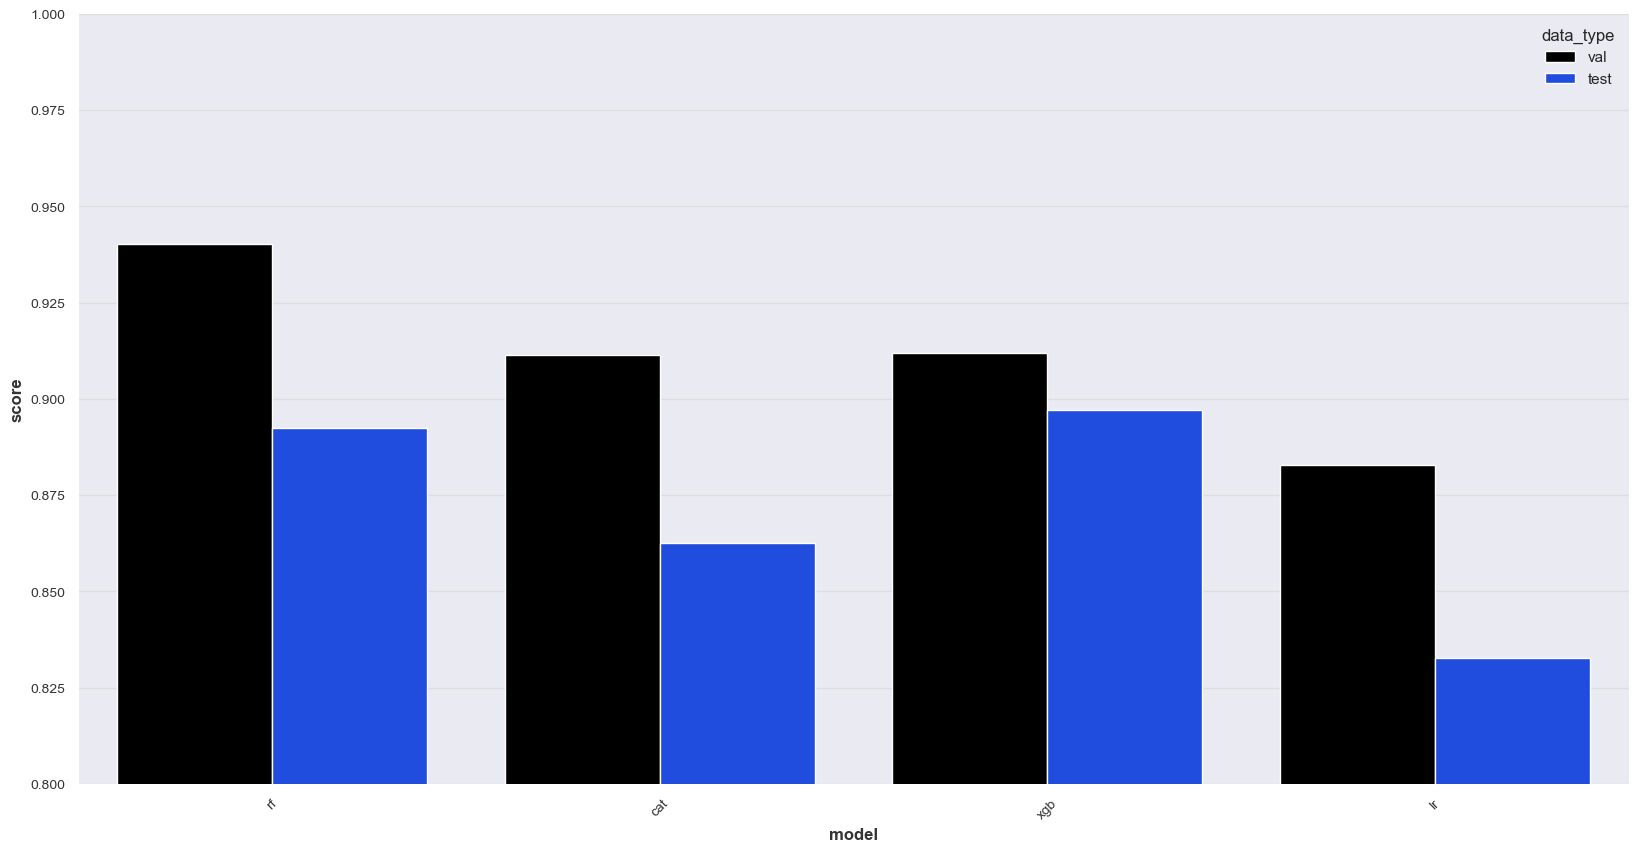

In [20]:
# metric이 pre인 데이터 중, x는 model, y는 score로 설정하여 시각화, hue는 data_type으로 설정
sns.barplot(x='model', y='score', hue='data_type', data=df[df['metric'] == 'pre'])
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.show()

In [54]:
clf_model = models['xgb']

In [55]:
clf_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# 에측 모델 (분류 모델 이후)

In [106]:
train_df = pre_train_df()
train_df, onehot_encoders = pre_all_onehot(train_df)

In [107]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df.shape, test_df.shape

((58851, 35), (546, 35))

In [108]:
# price가 0인 데이터 제거
trian_df = train_df[train_df['price'] != 0]
test_df = test_df[test_df['price'] != 0]

In [109]:
train_x = train_df.drop(['price', 'ts'], axis=1)
train_y = train_df['price']

test_x = test_df.drop(['price', 'ts'], axis=1)
test_y = test_df['price']

In [110]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((58851, 33), (58851,), (337, 33), (337,))

In [111]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y,
                                                  test_size=0.2, random_state=42)

In [ ]:
{'max_depth': 50, 
'n_estimators': 450, 
'max_features': 0.7563329247401375, 
'min_samples_leaf': 3, 
'min_samples_split': 8}

In [113]:
best_params = {'max_depth': 50, 
               'n_estimators': 450, 
               'max_features': 0.7563329247401375, 
               'min_samples_leaf': 3, 
               'min_samples_split': 8}

In [114]:
# model dict 생성
models = {
    # 'xgb': XGBRegressor(n_estimators=1000,
    #                     learning_rate=0.05),
    # 'lgbm': LGBMRegressor(n_estimators=1000,
    #                       learning_rate=0.05),
    'rf': RandomForestRegressor(**best_params),
    # 'cat': CatBoostRegressor(n_estimators=1000,
    #                          learning_rate=0.05,
    #                          verbose=100),
    # 'linear': LinearRegression(),
    # 'ridge': Ridge(),
    # 'lasso': Lasso(),
    # 'elastic': ElasticNet(),
    # 'sgd': SGDRegressor()
}

In [115]:
# model 학습
for model_name, model in models.items():
    print(model_name)
    try:
        model.fit(train_x, train_y,
                eval_set=[(val_x, val_y)],
                early_stopping_rounds=100,
                verbose=100,
                eval_metric='rmse')
    except:
        model.fit(train_x, train_y)

rf


In [31]:
def pre_1_reg_df():
    # model val 예측
    preds_val = {}
    for model_name, model in models.items():
        preds_val[model_name] = model.predict(val_x)

    # model test 예측
    preds_test = {}
    for model_name, model in models.items():
        preds_test[model_name] = model.predict(test_x)
    
    # 예측값이 0보다 작을 경우, 0으로 설정
    for model_name, pred in preds_val.items():
        preds_val[model_name] = np.where(pred < 0, 0, pred)
        
    for model_name, pred in preds_test.items():
        preds_test[model_name] = np.where(pred < 0, 0, pred)
        
        
    # val, test 회귀 모델의 rmse, r2 score 확인
    rmse_val = {}
    r2_val = {}
    rmse_test = {}
    r2_test = {}
    
    # rmse 및 r2 score 확인
    for model_name, pred in preds_val.items():
        rmse_val[model_name] = np.sqrt(mean_squared_error(val_y, pred))
        r2_val[model_name] = r2_score(val_y, pred)
        
    for model_name, pred in preds_test.items():
        rmse_test[model_name] = np.sqrt(mean_squared_error(test_y, pred))
        r2_test[model_name] = r2_score(test_y, pred)
        
    return rmse_val, r2_val, rmse_test, r2_test

In [32]:
rmse_val, r2_val, rmse_test, r2_test = pre_1_reg_df()

In [33]:
base = pd.DataFrame([rmse_val, r2_val, rmse_test, r2_test],
                    index=['rmse_val', 'r2_val', 'rmse_test', 'r2_test']).T
base

,rmse_val,r2_val,rmse_test,r2_test
xgb,909.444059,0.808944,848.050037,0.594531
rf,860.853093,0.828815,826.560410,0.614820
linear,1501.060412,0.479519,1126.027643,0.285154


In [116]:
def pre_1_reg_df():
    # model val 예측
    preds_val = {}
    for model_name, model in models.items():
        preds_val[model_name] = model.predict(val_x)

    # model test 예측
    preds_test = {}
    for model_name, model in models.items():
        preds_test[model_name] = model.predict(test_x)
    
    # 예측값이 0보다 작을 경우, 0으로 설정
    for model_name, pred in preds_val.items():
        preds_val[model_name] = np.where(pred < 0, 0, pred)
        
    for model_name, pred in preds_test.items():
        preds_test[model_name] = np.where(pred < 0, 0, pred)
        
        
    # val, test 회귀 모델의 rmse, r2 score 확인
    rmse_val = {}
    r2_val = {}
    rmse_test = {}
    r2_test = {}
    
    # rmse 및 r2 score 확인
    for model_name, pred in preds_val.items():
        rmse_val[model_name] = np.sqrt(mean_squared_error(val_y, pred))
        r2_val[model_name] = r2_score(val_y, pred)
        
    for model_name, pred in preds_test.items():
        rmse_test[model_name] = np.sqrt(mean_squared_error(test_y, pred))
        r2_test[model_name] = r2_score(test_y, pred)
        
    return rmse_val, r2_val, rmse_test, r2_test
rmse_val, r2_val, rmse_test, r2_test = pre_1_reg_df()
base = pd.DataFrame([rmse_val, r2_val, rmse_test, r2_test],
                    index=['rmse_val', 'r2_val', 'rmse_test', 'r2_test']).T
base

,rmse_val,r2_val,rmse_test,r2_test
rf,830.798576,0.840559,804.90371,0.63474


In [34]:
df = pd.DataFrame(columns=['data_type', 'model', 'metric', 'score'])
# base 값을 df에 넣기
for col in base.columns:
    metric, type = col.split('_')
    for idx in base.index:
        df = pd.concat([df, pd.DataFrame({'data_type': [type],
                                          'model': [idx],
                                          'metric': [metric],
                                          'score': [base.loc[idx, col]]})], ignore_index=True)

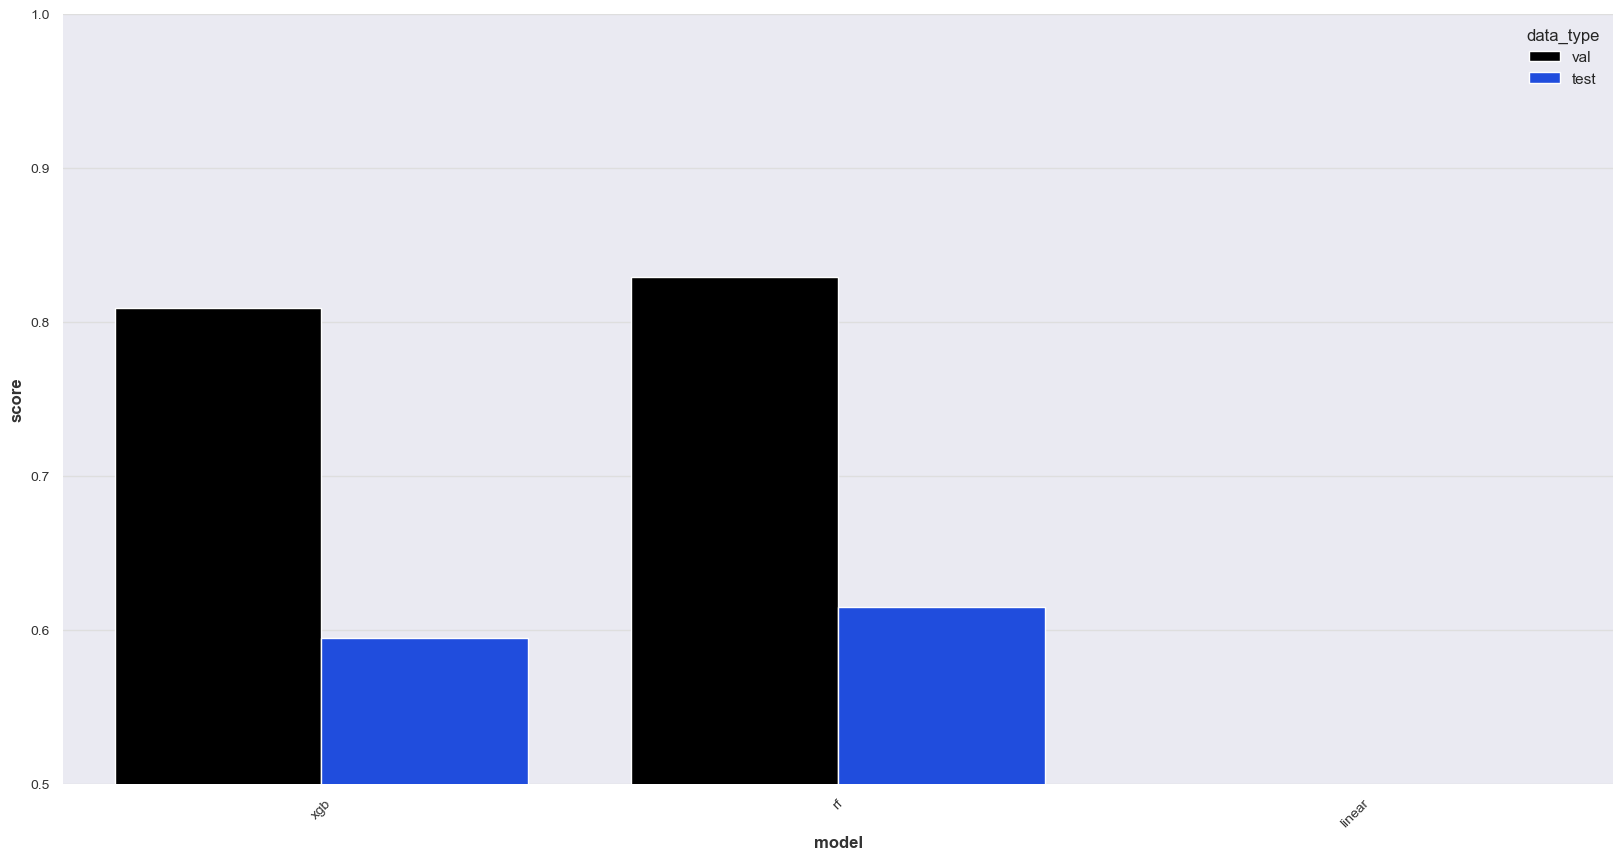

In [35]:
# metric이 r2인 데이터 중, x는 model, y는 score로 설정하여 시각화, hue는 data_type으로 설정
sns.barplot(x='model', y='score', hue='data_type', data=df[df['metric'] == 'r2'])
plt.xticks(rotation=45)
plt.ylim(0.5, 1.0)
plt.show()

In [102]:
reg_model = models['rf']

In [103]:
reg_model

RandomForestRegressor(n_estimators=1000)

In [105]:
# sklearn의 모델 저장
import joblib
joblib.dump(reg_model, 'reg_model2.pkl')

# sklearn의 모델 불러오기
# reg_model = joblib.load('reg_model.pkl')

['reg_model2.pkl']

In [56]:
# 분류 모델과 회귀 모델을 합친 모델 생성
class TotalModel():
    def __init__(self, clf_model, reg_model):
        self.clf_model = clf_model
        self.reg_model = reg_model
        
    def predict(self, x):
        clf_pred = self.clf_model.predict(x)
        clf_pred = np.where(clf_pred >= 0.5, 1, 0)
        reg_pred = self.reg_model.predict(x)
        
        # 분류 모델의 예측이 1이면 회귀 모델의 예측값을 반환
        # 분류 모델의 예측이 0이면 0을 반환
        pred = [reg_pred[i] if clf_pred[i] == 1 else 0 for i in range(len(clf_pred))]
        return pred

In [36]:
clf_model = tf.keras.models.load_model('./model/model_basic.h5')

In [57]:
total_model = TotalModel(clf_model, reg_model)

In [83]:
# ID를 입력하면 ID, price(원/kg) 칼럼만 있는 데이터프레임 생성
def pre_test_df(ID):
    test_df = pd.DataFrame({'ID': [ID],
                            'price(원/kg)': [0]})
    return test_df

In [84]:
id = 'TG_A_J_20220706'

In [90]:
test_df = pre_test_df(id)

In [91]:
pre_init_feature(test_df)
pre_ymd(test_df)
pre_timestamp(test_df)
pre_weekday(test_df)
pre_holiday(test_df)
pre_drop(test_df)

In [92]:
test_df

,price(원/kg),item,corporation,location,year,month,day,ts,weekday,holiday
0,0,TG,A,J,2022,7,6,2022-07-06,2,0


In [93]:
pre_cat_onehot_encoder_test(test_df)

,price(원/kg),day,ts,item_CB,item_CR,item_RD,item_TG,corporation_B,corporation_C,corporation_D,...,month_10,month_11,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,holiday_1
0,0,6,2022-07-06,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [58]:
train_df = pre_train_df()
train_df, onehot_encoders = pre_all_onehot(train_df)

In [59]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df.shape, test_df.shape

((58851, 35), (546, 35))

In [60]:
train_x = train_df.drop(['price', 'ts'], axis=1)
train_y = train_df['price']

test_x = test_df.drop(['price', 'ts'], axis=1)
test_y = test_df['price']

In [61]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((58851, 33), (58851,), (546, 33), (546,))

In [62]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y,
                                                  test_size=0.2, random_state=42)

In [63]:
# model val, test 예측
preds_val = total_model.predict(val_x)
preds_test = total_model.predict(test_x)

In [64]:
# val, test rmse, r2 score 확인
rmse_val = np.sqrt(mean_squared_error(val_y, preds_val))
r2_val = r2_score(val_y, preds_val)
rmse_test = np.sqrt(mean_squared_error(test_y, preds_test))
r2_test = r2_score(test_y, preds_test)

In [65]:
pd.DataFrame([rmse_val, r2_val, rmse_test, r2_test],
                index=['rmse_val', 'r2_val', 'rmse_test', 'r2_test']).T

,rmse_val,r2_val,rmse_test,r2_test
0,928.301548,0.800939,762.480192,0.749882


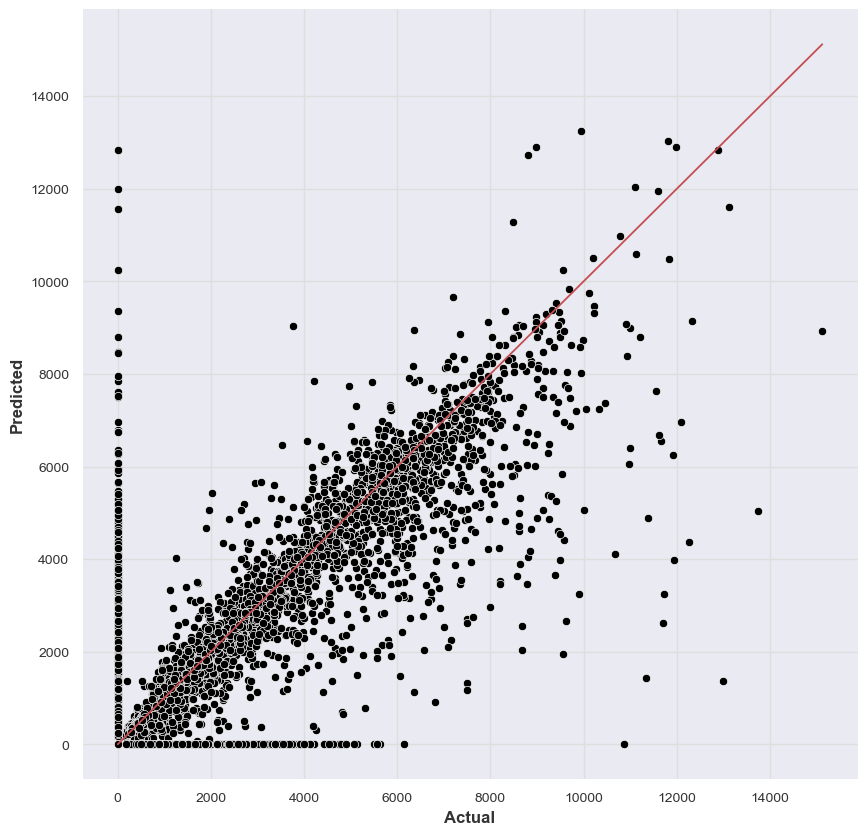

In [48]:
# val 실제값과 예측값 비교
plt.figure(figsize=(10, 10))
sns.scatterplot(x=val_y, y=preds_val)
plt.plot([0, val_y.max()], [0, val_y.max()], 'r-')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

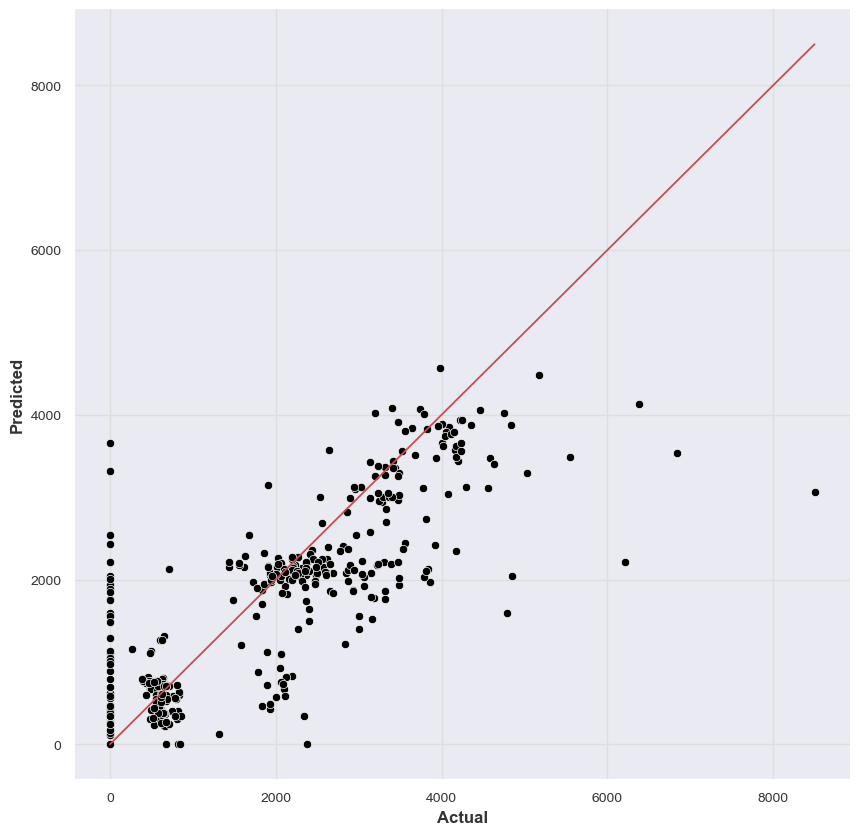

In [49]:
# test 실제값과 예측값 비교
plt.figure(figsize=(10, 10))
sns.scatterplot(x=test_y, y=preds_test)
plt.plot([0, test_y.max()], [0, test_y.max()], 'r-')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# 쌩 예측 모델 - 앙상블

In [50]:
train_df = pre_train_df()
train_df, onehot_encoders = pre_all_onehot(train_df)

In [51]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df.shape, test_df.shape

((58851, 35), (546, 35))

In [52]:
train_x = train_df.drop(['price', 'ts'], axis=1)
train_y = train_df['price']

test_x = test_df.drop(['price', 'ts'], axis=1)
test_y = test_df['price']

In [53]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((58851, 33), (58851,), (546, 33), (546,))

In [54]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y,
                                                  test_size=0.2, random_state=42)

In [55]:
# model dict 생성
models = {
    'xgb': XGBRegressor(n_estimators=1000,
                        learning_rate=0.05),
    # 'lgbm': LGBMRegressor(n_estimators=1000,
    #                       learning_rate=0.05),
    'rf': RandomForestRegressor(n_estimators=1000),
    # 'cat': CatBoostRegressor(n_estimators=1000,
    #                          learning_rate=0.05,
    #                          verbose=100),
    'linear': LinearRegression(),
    # 'ridge': Ridge(),
    # 'lasso': Lasso(),
    # 'elastic': ElasticNet(),
    # 'sgd': SGDRegressor()
}

In [56]:
# model 학습
for model_name, model in models.items():
    print(model_name)
    try:
        model.fit(train_x, train_y,
                eval_set=[(val_x, val_y)],
                early_stopping_rounds=100,
                verbose=100,
                eval_metric='rmse')
    except:
        model.fit(train_x, train_y)

xgb
[0]	validation_0-rmse:2017.29589


[100]	validation_0-rmse:1042.74764
[200]	validation_0-rmse:995.43545
[300]	validation_0-rmse:968.14575
[400]	validation_0-rmse:950.87627
[500]	validation_0-rmse:941.79344
[600]	validation_0-rmse:934.69096
[700]	validation_0-rmse:928.38539
[800]	validation_0-rmse:923.15215
[900]	validation_0-rmse:918.91582
[999]	validation_0-rmse:913.98865
rf
linear


In [57]:
rmse_val, r2_val, rmse_test, r2_test = pre_1_reg_df()

In [109]:
base = pd.DataFrame([rmse_val, r2_val, rmse_test, r2_test],
                    index=['rmse_val', 'r2_val', 'rmse_test', 'r2_test']).T
base

,rmse_val,r2_val,rmse_test,r2_test
xgb,909.444059,0.808944,798.051024,0.726001
rf,859.836033,0.829219,777.951687,0.739629
linear,1501.060412,0.479519,1122.556328,0.457869


In [110]:
df = pd.DataFrame(columns=['data_type', 'model', 'metric', 'score'])
# base 값을 df에 넣기
for col in base.columns:
    metric, type = col.split('_')
    for idx in base.index:
        df = pd.concat([df, pd.DataFrame({'data_type': [type],
                                          'model': [idx],
                                          'metric': [metric],
                                          'score': [base.loc[idx, col]]})], ignore_index=True)

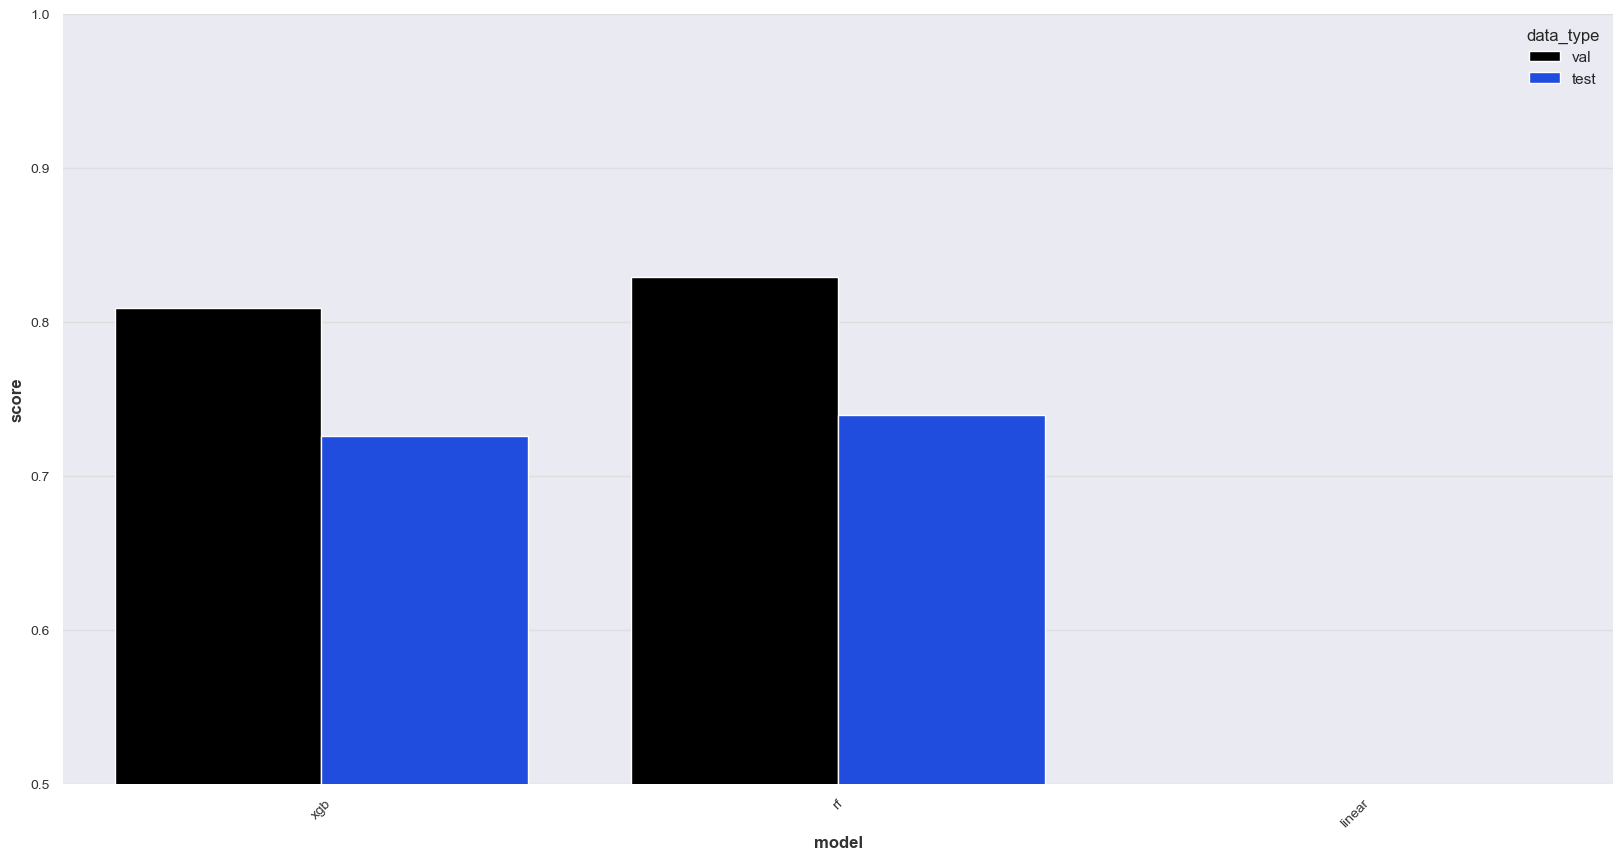

In [111]:
# metric이 r2인 데이터 중, x는 model, y는 score로 설정하여 시각화, hue는 data_type으로 설정
sns.barplot(x='model', y='score', hue='data_type', data=df[df['metric'] == 'r2'])
plt.xticks(rotation=45)
plt.ylim(0.5, 1.0)
plt.show()

In [59]:
reg_model = models['rf']

In [60]:
train_df = pre_train_df()
train_df, onehot_encoders = pre_all_onehot(train_df)

In [61]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df.shape, test_df.shape

((58851, 35), (546, 35))

In [62]:
train_x = train_df.drop(['price', 'ts'], axis=1)
train_y = train_df['price']

test_x = test_df.drop(['price', 'ts'], axis=1)
test_y = test_df['price']

In [63]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((58851, 33), (58851,), (546, 33), (546,))

In [64]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y,
                                                  test_size=0.2, random_state=42)

In [65]:
# model val, test 예측
preds_val = reg_model.predict(val_x)
preds_test = reg_model.predict(test_x)

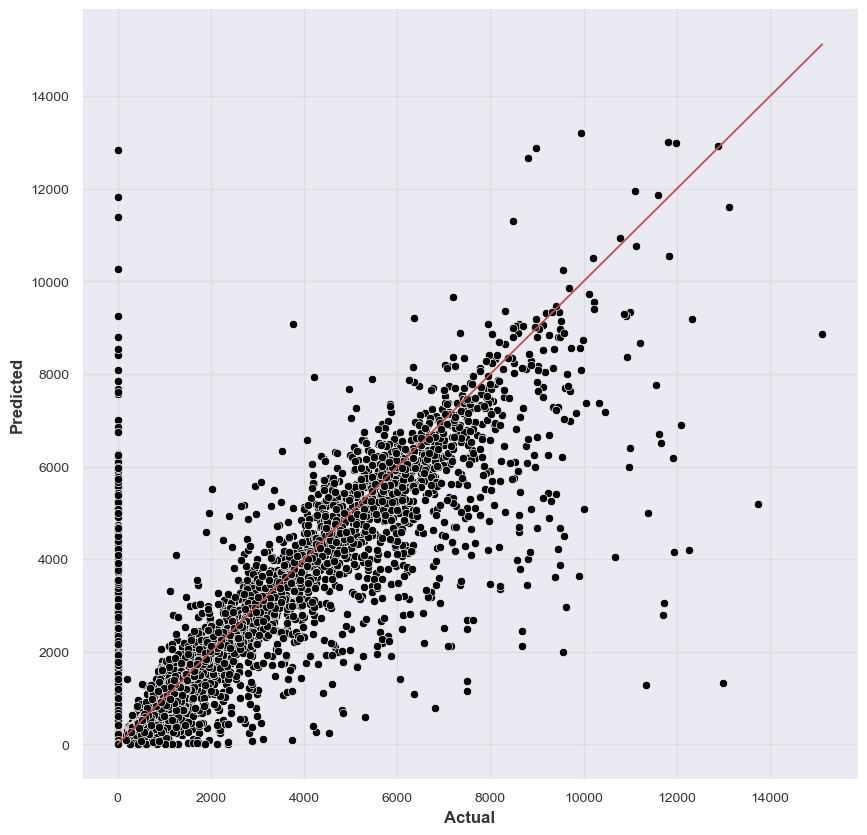

In [66]:
# val 실제값과 예측값 비교
plt.figure(figsize=(10, 10))
sns.scatterplot(x=val_y, y=preds_val)
plt.plot([0, val_y.max()], [0, val_y.max()], 'r-')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

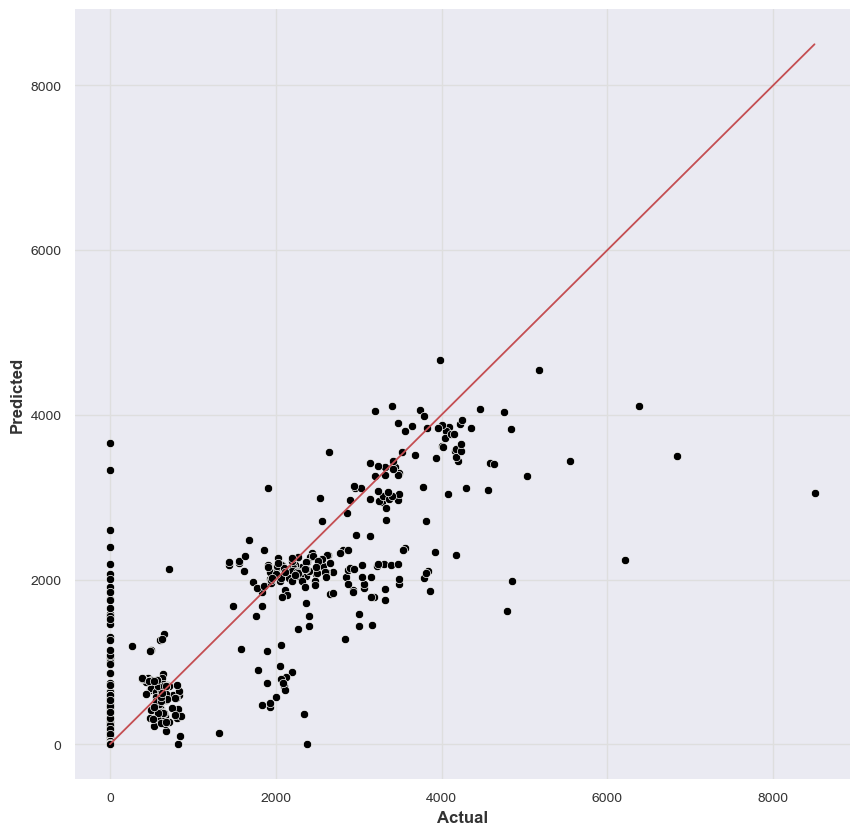

In [67]:
# test 실제값과 예측값 비교
plt.figure(figsize=(10, 10))
sns.scatterplot(x=test_y, y=preds_test)
plt.plot([0, test_y.max()], [0, test_y.max()], 'r-')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# 쌩 예측 모델 - 시계열

In [80]:
train_data['location'].unique()

array(['J', 'S'], dtype=object)

In [79]:
train_data

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0


In [74]:
train_df = pre_train_df()
train_df, label_encoders = pre_all_label(train_df)

In [68]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

In [69]:
# label_encoders에서 특정 칼럼의 인코더를 불러오고, inverse_transform으로 디코딩하는 함수
def inverse_transform_label_encoder(col, value):
    return label_encoders[col].inverse_transform([value])[0]

In [70]:
# 같은 item, corporation, location 별 리스트 생성
type_list = train_df.groupby(['item', 'corporation', 'location']).groups.keys()
type_list = list(type_list)

In [85]:
def train_and_predict(model_type, type_list, train_df):
    model_dict = {}
    pred_list = []
    
    for i in range(len(type_list)):
        # Extract data
        temp_df = train_df[(train_df['item'] == type_list[i][0]) &
                           (train_df['corporation'] == type_list[i][1]) &
                           (train_df['location'] == type_list[i][2])]
        ts = TimeSeries.from_dataframe(temp_df[['price']].astype('float32'))

        # Model creation and training
        if model_type == 'ARIMA':
            model = AutoARIMA(start_p=8, max_p=12, start_q=1)
        elif model_type == 'DLinear':
            model = DLinearModel(input_chunk_length=128, output_chunk_length=14,
                                 batch_size=256, n_epochs=50)
        model.fit(ts, verbose=False)
        model_dict[type_list[i]] = model

        # Prediction
        future = pd.DataFrame()
        future[model_type.lower()] = pd.date_range(start='2023-02-18', periods=14, freq='D')
        forecast = model.predict(len(future[model_type.lower()]), verbose=False)
        pred_y = forecast.values()
        
        # ID Generation
        item = inverse_transform_label_encoder('item', type_list[i][0])
        corporation = inverse_transform_label_encoder('corporation', type_list[i][1])
        location = inverse_transform_label_encoder('location', type_list[i][2])
        code = '_'.join([item, corporation, location])
        pred_code = [str(code)] * len(pred_y)
        
        timestamps = future[model_type.lower()].dt.strftime('%Y%m%d').values

        for id_test, timestamp, y_test in zip(pred_code, timestamps, pred_y):
            pred_list.append({'ID': '_'.join([id_test, timestamp]), model_type.lower(): y_test})

    return model_dict, pred_list


In [86]:
model_dict, pred_list = train_and_predict('DLinear', type_list, train_df)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, 

In [102]:
pred_DLinear = pd.DataFrame(pred_list)
pred_DLinear['dlinear'] = pred_DLinear['dlinear'].apply(lambda x : x[0])
pred_DLinear['dlinear'] = pred_DLinear['dlinear'].apply(lambda x : 0 if x < 0 else x)

In [103]:
# model_dict2, pred_list2 = train_and_predict('ARIMA', type_list, train_df)

In [104]:
# pred_ARIMA = pd.DataFrame(pred_list2)
# pred_ARIMA['arima'] = pred_ARIMA['arima'].apply(lambda x : x[0])
# pred_ARIMA['arima'] = pred_ARIMA['arima'].apply(lambda x : 0 if x < 0 else x)

In [106]:
# test_df와 pred_DLinear를 ID 기준으로 merge
result_df = pd.merge(test_df, pred_DLinear, on='ID', how='left')
# result_df = pd.merge(result_df, pred_ARIMA, on='ID', how='left')

In [107]:
# # test rmse, r2 계산 저장 및 모델별 성능 표 출력
rmse = np.sqrt(mean_squared_error(result_df['price'], result_df['dlinear']))
r2 = r2_score(result_df['price'], result_df['dlinear'])
rmse, r2

(865.9644239868287, 0.6773825052303379)

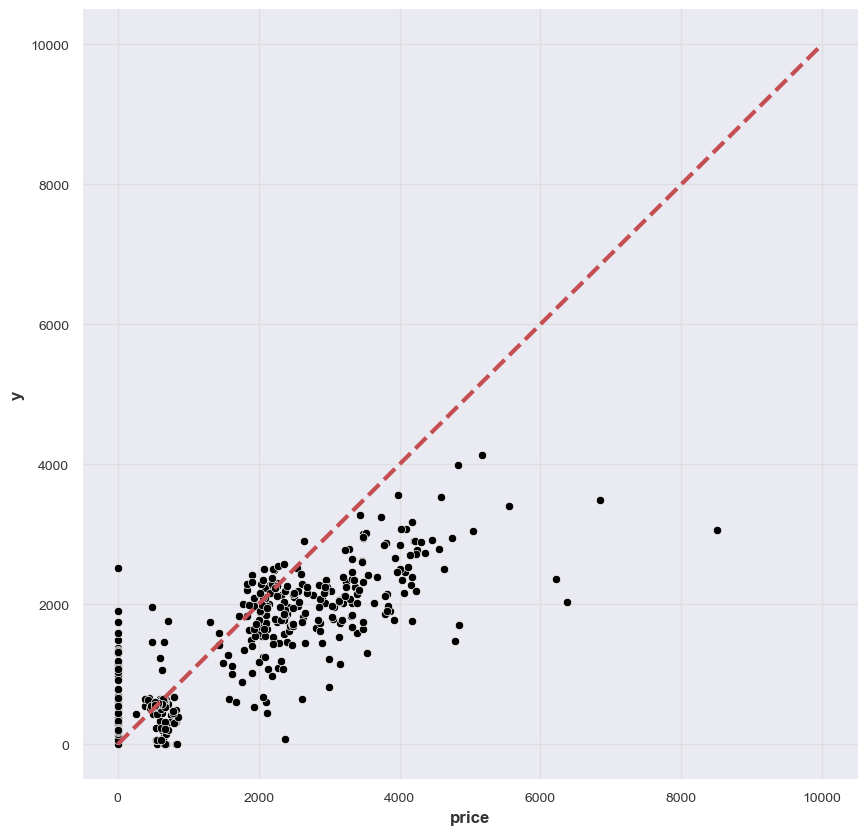

In [108]:
# test 데이터의 실제값과 예측값 비교 시각화, y=x 그래프 추가하기
plt.figure(figsize=(10, 10))
sns.scatterplot(x=result_df['price'], y=result_df['dlinear'])
plt.plot([0, 10000], [0, 10000], 'r--', linewidth=3)
plt.xlabel('price')
plt.ylabel('y')
plt.show()

# 최고의 모델 - 회귀

In [129]:
train_df = pre_train_df()
train_df, onehot_encoders = pre_all_onehot(train_df)

In [130]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df.shape, test_df.shape

((58851, 35), (546, 35))

In [131]:
# price가 0인 데이터 제거
trian_df = train_df[train_df['price'] != 0]
test_df = test_df[test_df['price'] != 0]

In [132]:
train_x = train_df.drop(['price', 'ts'], axis=1)
train_y = train_df['price']

test_x = test_df.drop(['price', 'ts'], axis=1)
test_y = test_df['price']

In [133]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((58851, 33), (58851,), (337, 33), (337,))

In [135]:
# 목적 함수 정의
def objective(params):
    params = {'max_depth': int(params['max_depth']),
              'n_estimators': int(params['n_estimators'])+1,
              'max_features': params['max_features'],
              'min_samples_leaf': int(params['min_samples_leaf']),
              'min_samples_split': int(params['min_samples_split'])}
    rf_model = RandomForestRegressor(**params)
    score = -cross_val_score(rf_model, train_x, train_y,
                             scoring='neg_mean_squared_error', cv=5).mean()
    return {'loss': score, 'status': STATUS_OK}

# 탐색 공간 정의
space = {
    'max_depth': hp.quniform('max_depth', 10, 100, 10),
    'n_estimators': hp.quniform('n_estimators', 10, 500, 50),
    'max_features': hp.uniform('max_features', 0.1, 1.0),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1),
    'min_samples_split': hp.quniform('min_samples_split', 8, 20, 2)
}

In [136]:
# 최적화 실행
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

100%|██████████| 100/100 [1:15:08<00:00, 45.08s/trial, best loss: 721608.6708225504]


In [137]:
# 최적 파라미터로 모델 훈련
best_params = {'max_depth': int(best['max_depth']),
               'n_estimators': int(best['n_estimators']),
               'max_features': best['max_features'],
               'min_samples_leaf': int(best['min_samples_leaf']),
               'min_samples_split': int(best['min_samples_split'])}
rfr_best_model = RandomForestRegressor(**best_params)
rfr_best_model.fit(train_x, train_y)

print("최적의 하이퍼파라미터:", best_params)

최적의 하이퍼파라미터: {'max_depth': 50, 'n_estimators': 450, 'max_features': 0.7563329247401375, 'min_samples_leaf': 3, 'min_samples_split': 8}


# 최고의 모델 - 분류

In [186]:
train_df = pre_train_df()
train_df, onehot_encoders = pre_all_onehot(train_df)

In [187]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df.shape, test_df.shape

((58851, 35), (546, 35))

In [188]:
train_df['price'] = train_df['price'].apply(
    lambda x: 1 if x != 0 else 0)
test_df['price'] = test_df['price'].apply(
    lambda x: 1 if x != 0 else 0)

In [189]:
train_x = train_df.drop(['price', 'ts'], axis=1)
train_y = train_df['price']

test_x = test_df.drop(['price', 'ts'], axis=1)
test_y = test_df['price']

In [190]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((58851, 33), (58851,), (546, 33), (546,))

In [191]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y,
                                                  test_size=0.2, random_state=42)

In [192]:
best_clf = XGBClassifier(n_estimators=100,
                            learning_rate=0.05)
best_clf.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [193]:
# 평가 - best_clf
preds_val = best_clf.predict(val_x)
preds_test = best_clf.predict(test_x)

# val, test 정확도, f1, precision 확인
acc_val = accuracy_score(val_y, preds_val)
f1_val = f1_score(val_y, preds_val, average='weighted')
pre_val = precision_score(val_y, preds_val, average='weighted')

acc_test = accuracy_score(test_y, preds_test)
f1_test = f1_score(test_y, preds_test, average='weighted')
pre_test = precision_score(test_y, preds_test, average='weighted')

print(f'val acc : {acc_val}, val f1 : {f1_val}, val pre : {pre_val}')
print(f'test acc : {acc_test}, test f1 : {f1_test}, test pre : {pre_test}')

val acc : 0.9099481777249172, val f1 : 0.9103232740344518, val pre : 0.9118042044051995
test acc : 0.8846153846153846, test f1 : 0.8802267691156581, test pre : 0.8971602377214624


In [194]:
# 평가 - rfr_best_model
preds_val = rfr_best_model.predict(val_x)
preds_test = rfr_best_model.predict(test_x)

# val, test rmse, r2 score 확인
rmse_val = np.sqrt(mean_squared_error(val_y, preds_val))
r2_val = r2_score(val_y, preds_val)

rmse_test = np.sqrt(mean_squared_error(test_y, preds_test))
r2_test = r2_score(test_y, preds_test)

print(f'val rmse : {rmse_val}, val r2 : {r2_val}')
print(f'test rmse : {rmse_test}, test r2 : {r2_test}')

val rmse : 2208.896266075441, val r2 : -20248182.696561214
test rmse : 1752.1541245837209, test r2 : -12994323.533229912


In [195]:
best_total_model = TotalModel(best_clf, rfr_best_model)

In [196]:
train_df = pre_train_df()
train_df, onehot_encoders = pre_all_onehot(train_df)

In [197]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df.shape, test_df.shape

((58851, 35), (546, 35))

In [198]:
train_x = train_df.drop(['price', 'ts'], axis=1)
train_y = train_df['price']

test_x = test_df.drop(['price', 'ts'], axis=1)
test_y = test_df['price']

In [199]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((58851, 33), (58851,), (546, 33), (546,))

In [200]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y,
                                                  test_size=0.2, random_state=42)

In [201]:
# model val, test 예측
preds_val = total_model.predict(val_x)
preds_test = total_model.predict(test_x)

In [202]:
# val, test rmse, r2 score 확인
rmse_val = np.sqrt(mean_squared_error(val_y, preds_val))
r2_val = r2_score(val_y, preds_val)
rmse_test = np.sqrt(mean_squared_error(test_y, preds_test))
r2_test = r2_score(test_y, preds_test)

In [203]:
pd.DataFrame([rmse_val, r2_val, rmse_test, r2_test],
                index=['rmse_val', 'r2_val', 'rmse_test', 'r2_test']).T

,rmse_val,r2_val,rmse_test,r2_test
0,927.903559,0.801109,763.39161,0.749284


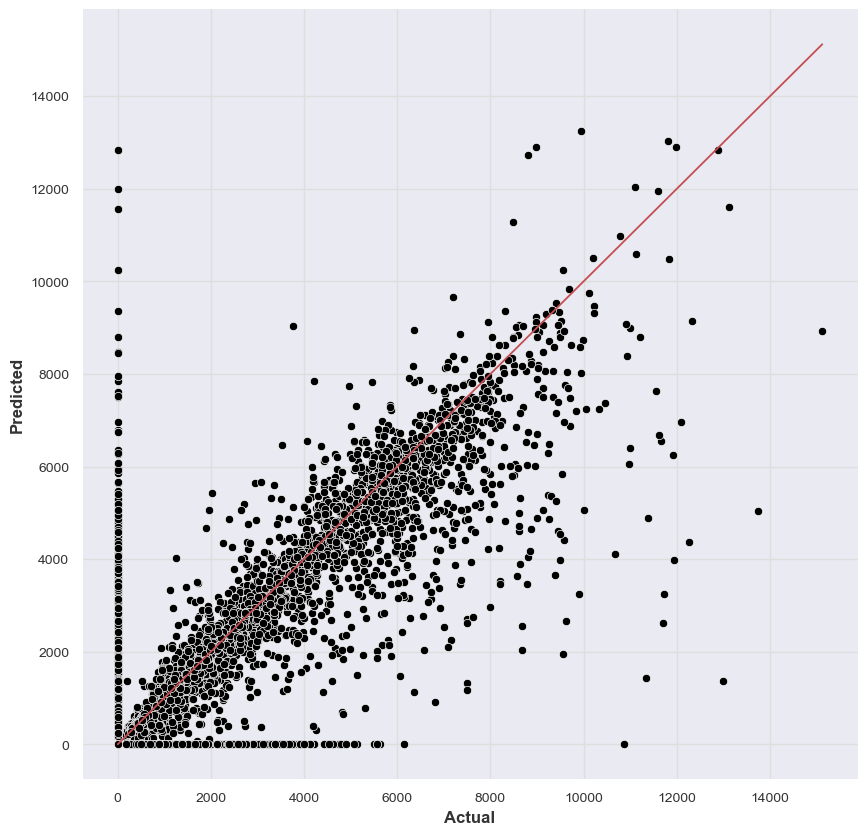

In [204]:
# val 실제값과 예측값 비교
plt.figure(figsize=(10, 10))
sns.scatterplot(x=val_y, y=preds_val)
plt.plot([0, val_y.max()], [0, val_y.max()], 'r-')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

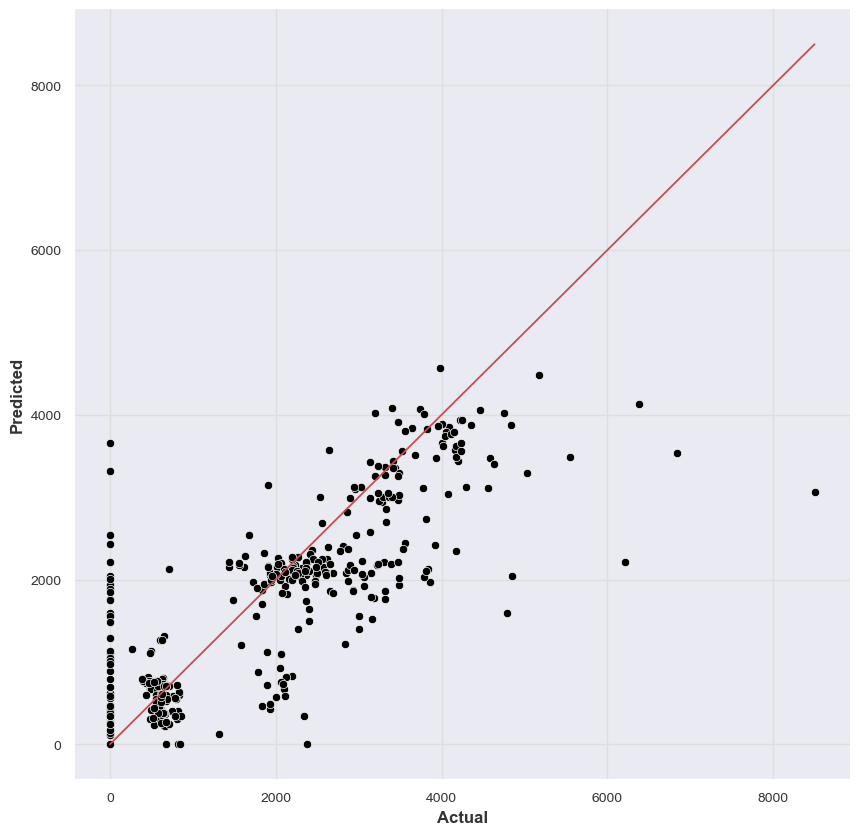

In [205]:
# test 실제값과 예측값 비교
plt.figure(figsize=(10, 10))
sns.scatterplot(x=test_y, y=preds_test)
plt.plot([0, test_y.max()], [0, test_y.max()], 'r-')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()